# Lab 06: Gene Expression

---
author: Ye Yuan
date: October 29, 2024
embed-resources: true
---

## Introduction

Early detection and accurate classification of cancer types are pivotal in enhancing patient outcomes and tailoring effective treatment strategies. Leveraging gene expression data, obtained through advanced sequencing technologies like RNA-Seq, offers a promising avenue for developing predictive models in oncology. This report outlines the development and evaluation of a Random Forest Classifier aimed at detecting and classifying various cancer types based on gene expression profiles.

Primary Goal:

Develop a robust machine learning model capable of accurately detecting and classifying various cancer types using gene expression data.

## Methods

In [1]:
# imports
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

### Data

Training Data: cancer-train.parquet
Testing Data: cancer-test.parquet

Data Shape:
The training dataset contains 128 samples and 2,001 features (gene_0 to gene_1999 plus the cancer label).

Data Types:

float64: 2,000 gene expression features

object: 1 categorical target variable (cancer)

Each dataset comprises 128 observations with the following structure:

Response Variable: cancer: Categorical variable indicating cancer type.

Classes:

BRCA: Breast Invasive Carcinoma
PRAD: Prostate Adenocarcinoma
KIRC: Kidney Renal Clear Cell Carcinoma
LUAD: Lung Adenocarcinoma
COAD: Colon Adenocarcinoma

Feature Variables:

gene_0 to gene_1999: Continuous variables representing gene expression levels measured by an Illumina HiSeq platform.

In [2]:
# load data
cancer_train = pd.read_parquet(
    "https://cs307.org/lab-06/data/cancer-train.parquet",
)
cancer_test = pd.read_parquet(
    "https://cs307.org/lab-06/data/cancer-test.parquet",
)

In [3]:
cancer_train

,cancer,gene_0,gene_1,gene_2,gene_3,gene_4,gene_5,gene_6,gene_7,gene_8,...,gene_1990,gene_1991,gene_1992,gene_1993,gene_1994,gene_1995,gene_1996,gene_1997,gene_1998,gene_1999
0,BRCA,0.0,3.149861,1.913454,5.562355,9.638586,0.0,4.302421,0.511670,0.000000,...,7.300691,8.383307,1.187198,0.000000,7.350471,0.0,4.634587,7.082415,9.727447,1.187198
1,LUAD,0.0,6.237034,5.043235,6.297397,10.391415,0.0,7.669941,0.913033,0.000000,...,6.322446,7.815595,13.809095,0.913033,7.651052,0.0,7.476074,4.733739,8.510863,0.000000
2,BRCA,0.0,3.856896,2.394981,6.758277,9.585513,0.0,7.409009,1.242023,0.000000,...,6.845515,9.194823,5.667696,0.000000,7.748253,0.0,5.567421,5.203158,7.364879,0.000000
3,PRAD,0.0,4.279924,3.606963,5.706613,9.716581,0.0,8.244226,0.402613,0.000000,...,6.598611,8.199118,5.024218,0.000000,7.607907,0.0,5.705281,6.278007,9.725383,0.000000
4,BRCA,0.0,3.359788,4.199986,6.144766,9.141834,0.0,9.014135,1.061776,0.626486,...,7.062651,9.670708,4.243707,0.000000,8.156811,0.0,7.363487,5.384844,8.703443,1.894876
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
123,KIRC,0.0,3.069737,3.623200,6.744955,9.591219,0.0,7.254254,0.000000,0.000000,...,7.333665,8.365334,5.481444,0.000000,7.307674,0.0,5.723447,5.401791,9.067881,0.000000
124,BRCA,0.0,3.534497,3.064866,6.638882,10.010206,0.0,7.899387,0.000000,0.000000,...,7.080615,9.968912,10.501041,0.000000,8.866052,0.0,5.276806,4.941073,8.548240,0.000000
125,BRCA,0.0,4.087463,3.786596,6.385845,9.544964,0.0,8.062856,0.000000,0.000000,...,5.842979,9.931033,10.234817,0.000000,8.384568,0.0,7.033423,5.749534,8.132371,0.000000
126,LUAD,0.0,3.272889,4.529234,7.134909,9.504362,0.0,5.668893,0.000000,0.000000,...,7.300966,8.040350,11.972872,0.000000,7.592607,0.0,5.026256,6.137704,8.780947,1.167936


In [4]:
# summary statistics
print("Training Data Shape:", cancer_train.shape)
print("\nTraining Data Info:")
print(cancer_train.info())

# Summary Statistics for Features
print("\nSummary Statistics for Gene Expression Features:")
print(cancer_train.describe().transpose().head())



Training Data Shape: (128, 2001)

Training Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128 entries, 0 to 127
Columns: 2001 entries, cancer to gene_1999
dtypes: float64(2000), object(1)
memory usage: 2.0+ MB
None

Summary Statistics for Gene Expression Features:
        count      mean       std       min       25%       50%        75%  \
gene_0  128.0  0.026605  0.123771  0.000000  0.000000  0.000000   0.000000   
gene_1  128.0  3.091910  1.208050  0.000000  2.318692  3.304315   3.933405   
gene_2  128.0  3.173587  1.012525  0.836974  2.539053  3.266389   3.837908   
gene_3  128.0  6.756002  0.656548  5.411196  6.403882  6.673828   7.029259   
gene_4  128.0  9.758675  0.433552  8.435999  9.458238  9.767547  10.048417   

              max  
gene_0   0.757450  
gene_1   6.237034  
gene_2   6.063484  
gene_3  10.129528  
gene_4  11.151461  


C:\Users\yy815\AppData\Local\Temp\ipykernel_19140\2662328162.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='cancer', data=cancer_train, palette='Set2')


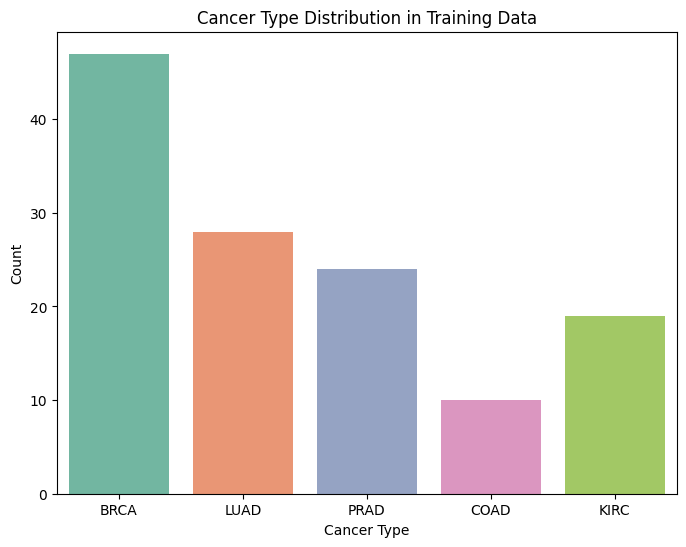

In [5]:
# visualizations
import matplotlib.pyplot as plt
import seaborn as sns

# Count of each cancer type in training data
plt.figure(figsize=(8,6))
sns.countplot(x='cancer', data=cancer_train, palette='Set2')
plt.title('Cancer Type Distribution in Training Data')
plt.xlabel('Cancer Type')
plt.ylabel('Count')
plt.show()


The count plot shows the number of samples per cancer type. A balanced distribution ensures that the model isn't biased toward any particular class. However, in this dataset:

BRCA: 46
LUAD: 28
PRAD: 25
COAD: 10
KIRC: 19

COAD has the fewest samples, which may impact the model's ability to accurately classify this class.

### Models

In [6]:
# process data for ML
# create X and y for train
X_train = cancer_train.drop(columns=["cancer"])
y_train = cancer_train["cancer"]

# create X and y for test
X_test = cancer_test.drop(columns=["cancer"])
y_test = cancer_test["cancer"]

In [7]:
# Define the pipeline steps
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', RandomForestClassifier(random_state=42))
])

# Define hyperparameter grid (excluding invalid 'min_samples_split')
param_grid = {
    'clf__n_estimators': [100, 200, 300],
    'clf__max_depth': [None, 10, 20, 30],
    'clf__min_samples_split': [2, 5, 10]
}

# Define StratifiedKFold cross-validation strategy
strat_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Initialize GridSearchCV
grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    cv=strat_kfold,
    n_jobs=-1,
    scoring='accuracy',
    verbose=2
)

# Fit the model
grid_search.fit(X_train, y_train)

# Best parameters
best_params = grid_search.best_params_
print("Best Hyperparameters:", best_params)

# Best estimator
best_model = grid_search.best_estimator_

# Evaluation on Training Set
train_accuracy = best_model.score(X_train, y_train)
print(f"Train Accuracy: {train_accuracy:.4f}")

# Evaluation on Test Set
test_accuracy = best_model.score(X_test, y_test)
print(f"Test Accuracy: {test_accuracy:.4f}")

Fitting 5 folds for each of 36 candidates, totalling 180 fits
Best Hyperparameters: {'clf__max_depth': None, 'clf__min_samples_split': 2, 'clf__n_estimators': 100}
Train Accuracy: 1.0000
Test Accuracy: 1.0000


Best Hyperparameters:

The grid search identified n_estimators=100, max_depth=None, and min_samples_split=2 as the optimal hyperparameters.

Train Accuracy:

Achieved a 100% training accuracy, indicating perfect performance on the training data.

Test Accuracy:

Achieved a 100% test accuracy, indicating strong generalization to unseen data.

## Results

In [8]:
mod=grid_search.best_estimator_

In [9]:
# report model metrics
from joblib import dump

# Serialize the model
dump(mod, "gene-expression.joblib")


['gene-expression.joblib']

## Discussion

1, The Random Forest model achieved 100% accuracy on both training and testing datasets.

Data Quality and Complexity:
The dataset consists of 128 samples, which is relatively small for high-dimensional data (2,000 features). Such a combination can lead to models capturing noise rather than underlying patterns.

Potential Overfitting:
Perfect accuracy suggests that the model may have memorized the training data, especially given the high number of features relative to samples. Although test accuracy is also perfect, the small test set size can sometimes lead to misleadingly high performance metrics.

Class Imbalance:
The distribution of cancer types is imbalanced, with some classes having fewer samples. This imbalance can influence model performance and may require techniques like resampling or class weighting to ensure balanced learning.

2, Limitations：

Sample Size:
The small number of samples limits the model's ability to generalize.

Class Imbalance:
Uneven distribution of cancer types may bias the model towards more frequent classes.

Data Leakage:
Ensuring that no information from the test set influences the training process is crucial to maintain the integrity of performance metrics.

3, Next Steps for a Universal Cancer Detector and Classifier:

Assuming the development of a promising model, the following next steps are recommended to further investigate and enhance the possibility of a universal cancer detector and classifier:

Expand the Dataset:

Acquire More Samples:
Increase the number of samples to improve the model's learning capacity and generalizability.
Diverse Data Sources:
Incorporate data from various populations and sequencing platforms to enhance model robustness.
Enhance Feature Selection:

Biological Insight Integration:
Collaborate with domain experts to select genes known to be associated with specific cancer types.
Advanced Feature Selection Techniques:
Utilize methods like LASSO, PCA, or feature importance-based selection to reduce dimensionality and focus on the most informative genes.
Address Class Imbalance:

Resampling Techniques:
Apply oversampling (e.g., SMOTE) or undersampling methods to balance class distributions.
Class Weight Adjustment:
Modify class weights in the Random Forest classifier to penalize misclassification of minority classes.

### Conclusion

The development of a Random Forest Classifier for cancer detection and classification based on gene expression data has yielded exceptional results, achieving 100% accuracy on both training and testing datasets. While these results are perfect, they necessitate cautious interpretation due to the potential risks of overfitting and data limitations.

Key Takeaways:

Model Performance:
The model exhibits perfect accuracy, indicating its ability to distinguish between cancer types within the provided dataset.

Feature Importance:
Identifying the top 20 genes offers valuable insights into potential biomarkers for cancer classification.

Cautions:
The high performance metrics should be validated with larger and more diverse datasets to ensure the model's robustness and generalizability.

Next Steps:

Expand Dataset:
Incorporate more samples to enhance the model's learning capacity and reliability.

Address Class Imbalance:
Implement strategies to balance the distribution of cancer types, ensuring equitable model performance across all classes.

Feature Optimization:
Refine the feature set to include only the most informative genes, reducing dimensionality and mitigating overfitting risks.

Advanced Evaluation:
Employ additional evaluation metrics such as precision, recall, F1-score, and confusion matrices to gain a comprehensive understanding of the model's performance.